### Preparation steps

Install iotfunctions with

`pip install git+https://github.com/ibm-watson-iot/functions@development`

This projects contains the code for the Analytics Service pipeline as well as the anomaly functions and should pull in most of this notebook's dependencies.

The plotting library matplotlib is the exception, so you need to run
`pip install matplotlib`


In [15]:
# Real life data

import logging
import threading
import itertools
import pandas as pd  
import numpy as np  
import json
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d
import seaborn as seabornInstance
from sqlalchemy import Column, Integer, String, Float, DateTime, Boolean, func
from iotfunctions import base
from iotfunctions import bif
from iotfunctions import entity
from iotfunctions import metadata
from iotfunctions.metadata import EntityType
from iotfunctions.db import Database
from iotfunctions.dbtables import FileModelStore
from iotfunctions.enginelog import EngineLogging
from iotfunctions import estimator
from iotfunctions.ui import (UISingle, UIMultiItem, UIFunctionOutSingle,
                 UISingleItem, UIFunctionOutMulti, UIMulti, UIExpression,
                 UIText, UIStatusFlag, UIParameters)
from mmfunctions.anomaly import (SaliencybasedGeneralizedAnomalyScore, SpectralAnomalyScore,
                                 GeneralizedAnomalyScore,
                 FFTbasedGeneralizedAnomalyScore, KMeansAnomalyScore, SaliencybasedGeneralizedAnomalyScoreV2, 
                 FFTbasedGeneralizedAnomalyScoreV2, KMeansAnomalyScoreV2, MatrixProfileAnomalyScore)                 
import datetime as dt
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

EngineLogging.configure_console_logging(logging.INFO)

In [16]:
# setting to make life easier
Temperature='Temperature'
kmeans0='TemperatureKmeansScore0'
kmeans='TemperatureKmeansScore'
fft0='FFTAnomalyScore0'
mat0='MatrixProfileAnomalyScore'
fft='FFTAnomalyScore'
spectral='TemperatureSpectralScore'
sal='SaliencyAnomalyScore'
gen='TemperatureGeneralizedScore'
kmeansA='kmeansAnomaly'
kmeansA0='kmeansAnomaly0'
spectralA='spectralAnomaly'
fftA0='fftAnomaly0'
fftA='fftAnomaly'
salA='salAnomaly'
genA='genAnomaly'
matA0='matAnomaly'

kmeans_break=1.3
spectral_break = 100
fft_break = 100
sal_break = 100
gen_break = 30000
mat_break = 1



#### What will be shown

General approach is straightforward
* read raw data in
* transform it so that it is compatible to the Monitoring pipeline
* add yet another anomaly detector based on computer vision technology. The point here is to show how to run pipeline anomaly functions 'locally', an important concept for automated testing.
* simplify the dataframe - we have only one entity, no need for an entity index
* render input data and anomaly scores properly scaled

<br>

We start with Microsoft's anomaly test data found here
https://github.com/microsoft/anomalydetector/blob/master/samples/sample.csv

and then proceed to applying anomaly detection to real life pump data


<br>


#### Current inventory of anomaly detectors by type

This is the list of functions to apply


| Detector | ML Type | Type         | How does it work |
| ------- | ------------ | ------- | ---------------- |
| KMeans | Unsupervised | Proximity | Clusters data points in centroid buckets, small buckets are outliers, score is distance to closest other bucket |
| Generalized | Unsupervised | Linear Model | Covariance matrix over data point vectors serves to measure multi-dimensional deviation |
| FFT | Unsupervised | Linear Model | Run FFT before applying Generalized |
| Spectral | Unsupervised | Linear Model | Compute signal energy to reduce dimensions |
| Saliency | Unsupervised | Linear Model | Apply saliency transform (from computer vision |
| SimpleAnomaly | **Supervised** | Ensemble | Run Gradient boosting on training data, anomaly if prediction deviates from actual data |
| --- | **Supervised** | LSTM | Train a stacked LSTM, anomaly if prediction deviates from actual data |



In [17]:
# set up a db object with a FileModelStore to support scaling
#with open('credentials_as_monitor_demo.json', encoding='utf-8') as F:
#    credentials = json.loads(F.read())
#db_schema=None
#fm = FileModelStore()
#db = Database(credentials=credentials, model_store=fm)
#print (db)

db_schema=None
class DatabaseDummy:
    tenant_id = '###_IBM_###'
    db_type = 'db2'
    model_store = FileModelStore()
    def _init(self):
        return

db = DatabaseDummy()
        
print (db.tenant_id)

2022-05-31T19:47:11.967 INFO iotfunctions.dbtables.__init__ Init FileModelStore with path: 
###_IBM_###


In [24]:
# Run on the good pump first 
# Get stuff in
#df_i = pd.read_csv('./data/PDS_MMANOMALY_DM_AZURE_202202231039.csv', index_col=False)
#df_i = pd.read_csv('./data/PDS_MMANOMALY_DM_AZURE_202202241023.csv', index_col=False)
df_i = pd.read_csv('/home/markus/src/pipeline-2.0-poc-kafka/com.ibm.wiotp.internal.pipeline.catalog/src/test/resources/AzureAnomalyIsolationScores.csv', index_col=False)

#df_i.rename(columns={'TIMESTAMP':'timestamp','INPUTVALUE':'Temperature'}, inplace=True)
df_i.rename(columns={'timeticks':'timestamp', 'value':'Temperature'}, inplace=True)

df_i['entity']='MyRoom'
df_i['timestamp'] = pd.to_datetime(df_i['timestamp'], format='%Y-%m-%d-%H.%M.%S.%f')

df_o = df_i.copy()
#df_i[Temperature]=df_i['wss2speed']
#df_i = df_i.drop(columns=['value'])

# and sort it by timestamp
df_i = df_i.sort_values(by='ORIGINALINDEX')
df_i = df_i.drop_duplicates(subset='ORIGINALINDEX')
df_i = df_i.set_index(['entity','timestamp']).dropna()


KeyError: 'timestamp'

In [5]:
lg = df_i['ORIGINALINDEX'].shape[0]

In [6]:
# Now run the anomaly functions as if they were executed in a pipeline

jobsettings = { 'db': db, 
               '_db_schema': 'public', 'save_trace_to_file' : True}

slide = 60
winsize = 240

ll = np.arange(0, lg, slide)
geni = GeneralizedAnomalyScore(Temperature, 12, gen)
et = geni._build_entity_type(columns = [Column(Temperature,Float())], **jobsettings)
geni._entity_type = et

res = []
long_res = []

for l in ll:
    df_k = df_i[l:min(l+winsize, lg)].copy()
    print(l)
    df_k = geni.execute(df=df_k)
    res.append(df_k[gen].values[:slide])
    long_res.append(df_k[gen].values)

#df_i[gen] = np.concatenate(res)

2022-05-31T19:46:51.411 INFO iotfunctions.metadata.__init__ The entity type is not connected to a metric input table.
0
2022-05-31T19:46:51.416 INFO mmfunctions.anomaly.execute db is <__main__.DatabaseDummy object at 0x7fde258ae0e0>
60
2022-05-31T19:46:51.478 INFO mmfunctions.anomaly.execute db is <__main__.DatabaseDummy object at 0x7fde258ae0e0>
120
2022-05-31T19:46:51.513 INFO mmfunctions.anomaly.execute db is <__main__.DatabaseDummy object at 0x7fde258ae0e0>
180
2022-05-31T19:46:51.547 INFO mmfunctions.anomaly.execute db is <__main__.DatabaseDummy object at 0x7fde258ae0e0>
240
2022-05-31T19:46:51.581 INFO mmfunctions.anomaly.execute db is <__main__.DatabaseDummy object at 0x7fde258ae0e0>
300
2022-05-31T19:46:51.615 INFO mmfunctions.anomaly.execute db is <__main__.DatabaseDummy object at 0x7fde258ae0e0>
360
2022-05-31T19:46:51.651 INFO mmfunctions.anomaly.execute db is <__main__.DatabaseDummy object at 0x7fde258ae0e0>
420
2022-05-31T19:46:51.686 INFO mmfunctions.anomaly.execute db is

/home/markus/.local/lib/python3.10/site-packages/sklearn/covariance/_robust_covariance.py:738: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn(


In [7]:
w = np.concatenate(res)
if w.shape[0] < lg:
    w = np.concatenate([w, np.zeros(lg-w.shape[0])])
w.shape

(3960,)

In [18]:
df_i[gen] = w

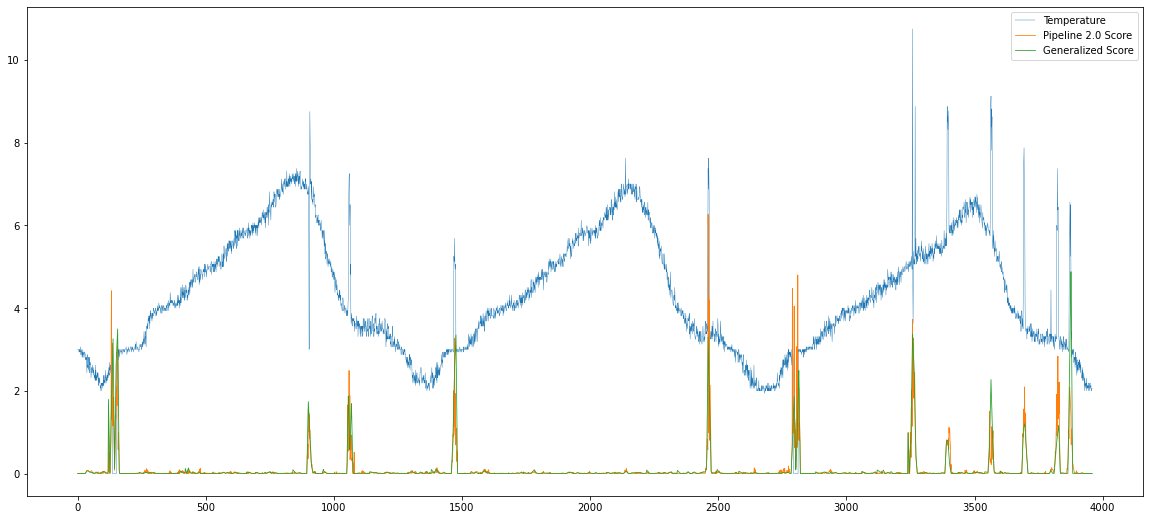

In [19]:
rg = range(df_i['Temperature'].size)
fig = plt.figure(figsize=(20, 9))

plt.plot(rg, df_i[Temperature], lw=0.4, label='Temperature')
plt.plot(rg, df_i['SCORE']/10, lw=0.8, label='Pipeline 2.0 Score');
plt.plot(rg, df_i[gen]/10, lw=0.8, label='Generalized Score');
plt.legend()

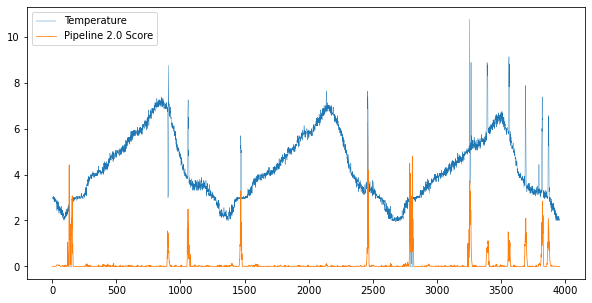

In [10]:
rg = range(df_i['Temperature'].size)
fig = plt.figure(figsize=(10, 5))

plt.plot(rg, df_i[Temperature], lw=0.4, label='Temperature')
plt.plot(rg, df_i['SCORE']/10, lw=0.8, label='Pipeline 2.0 Score');
#plt.plot(rg, df_i[gen]/10, lw=0.8, label='Generalized Score');
plt.legend()

In [11]:
test_list = ['b','c',None, 'd']
','.join(list(filter(None, test_list)))

'b,c,d'

In [12]:
import uuid
import hashlib
def hash_password(password):
    # uuid is used to generate a random number.
    #salt = uuid.uuid4().hex
    salt = 'astwertfdaew55ddfaw4dfasdfwtv0q3aifadsfa[reydf]'
    return hashlib.sha256(salt. encode() + password. encode()).hexdigest() + ':' + salt

def check_password(hashed_password, user_password):
    password, salt = hashed_password.split(':') 
    return password == hashlib.sha256(salt.encode() + user_password.encode()).hexdigest()

In [13]:
password = '61c2f5assfasdfasdfsadf216c8ca9f40454abf9d94f5bcd1633e24df3616cf221b7bf93cdc89762:ad030f7fa3db4b359cd90ed5699fac9ablah'

In [14]:
hashvalue = hash_password(password)

In [89]:
check_password(hashvalue, password)

True

In [90]:
len(hashvalue)

112